# Poisoning Attacks against Machine Learning models

In this tutorial we will experiment with **adversarial poisoning attacks** 
 against a Support Vector Machine (SVM) with Radial Basis Function (RBF) kernel.

Poisoning attacks are performed at *train time* by injecting *carefully crafted 
 samples* that alter the classifier decision function so that its accuracy decreases.

As in the previous tutorials, we will first create and train the classifier, 
 evaluating its performance in the standard scenario, *i.e. not under attack*.
 The poisoning attack will also need a *validation set* to verify the classifier
 performance during the attack, so we split the training set furtherly in two.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/pralab/secml/blob/HEAD/tutorials/05-Poisoning.ipynb)

In [1]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

try:
  import secml
except ImportError:
  %pip install git+https://gitlab.com/secml/secml

In [2]:
import numpy as np

random_state = 999

n_features = 5  # Number of features
n_samples = 300  # Number of samples
centers = [[-1, -1, -1, -1, -1], [+1, +1, +1,+1, +1]]  # Centers of the clusters
# centers = [[-1, -1], [+1, +1]]
cluster_std = 0.9  # Standard deviation of the clusters

from secml.data.loader import CDLRandomBlobs
from secml.data.loader import CDataLoader
from secml.array import CArray
dataset = CDLRandomBlobs(n_features=n_features, 
                         centers=centers, 
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()
print(dataset)



arr = np.array([[1,0,2], [4,0,5]])
print(arr)
n_tr = 100  # Number of training set samples
n_val = 100  # Number of validation set samples
n_ts = 100  # Number of test set samples

# Split in training, validation and test
from secml.data.splitter import CTrainTestSplit
splitter = CTrainTestSplit(
    train_size=n_tr + n_val, test_size=n_ts, random_state=random_state)
tr_val, ts = splitter.split(dataset)
splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_val, random_state=random_state)
tr, val = splitter.split(dataset)


# Normalize the data
from secml.ml.features import CNormalizerMinMax
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
val.X = nmz.transform(val.X)
ts.X = nmz.transform(ts.X)

# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
# clf = CClassifierRidge()
# clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr.X, tr.Y)
print("Training of classifier complete!")
print(type(tr))


# print(tr.Y)

# print(tr.X)
# Compute predictions on a test set
y_pred = clf.predict(ts.X)

CDataset{'X': CArray(300, 5)(dense: [[-2.000074 -2.076864 -1.938544 -1.908062 -2.271961] [-0.885558  0.261702 -0.716667 -1.772604 -1.239521] [-0.91966  -1.825762 -0.743364 -0.969764  0.036916] ... [-0.208939 -1.335812 -0.5236   -0.716496 -0.592481] [-0.344799 -2.091096 -0.612476 -1.896267 -0.097316] [-0.798157 -1.930209 -0.648004 -1.021098 -1.139021]]), 'Y': CArray(300,)(dense: [0 0 0 ... 0 0 0]), 'header': None}
[[1 0 2]
 [4 0 5]]
Training of classifier complete!
<class 'secml.data.c_dataset.CDataset'>


## 对spambase进行攻击

Training of classifier complete!
Initial poisoning sample features: CArray([0.037445 0.       0.05098  ... 0.000599 0.001902 0.064109])
Initial poisoning sample label: 0
Attack started...
Attack complete!
Original accuracy on test set: 83.19%
Accuracy after attack on test set: 11.65%


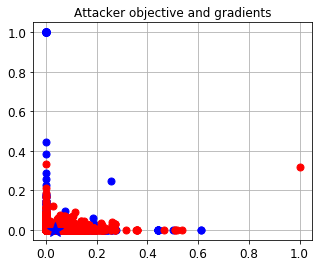

In [14]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax
import pickle
#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]



df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]
test_x = data_test_array



#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
# clf = CClassifierRidge()
# clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
pois_attack = CAttackPoisoningSVM(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 3000  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_svm_adv = pois_ds


# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))




In [15]:
import pickle
with open('pois_ds_svm_adv','wb') as file:
    pickle.dump(pois_ds_svm_adv,file)

In [16]:
pois_ds_svm_adv_X_array = pois_ds_svm_adv.X.tondarray()
pois_ds_svm_adv_y_array = pois_ds_svm_adv.Y.tondarray()
with open('pois_ds_svm_adv_X_array','wb') as file:
    pickle.dump(pois_ds_svm_adv_X_array,file)
with open('pois_ds_svm_adv_y_array','wb') as file:
    pickle.dump(pois_ds_svm_adv_y_array,file)

Training of classifier complete!
Initial poisoning sample features: CArray([0.068528 0.018908 0.       ... 0.00021  0.000501 0.009939])
Initial poisoning sample label: 0
Attack started...
Attack complete!
Original accuracy on test set: 84.86%
Accuracy after attack on test set: 78.54%


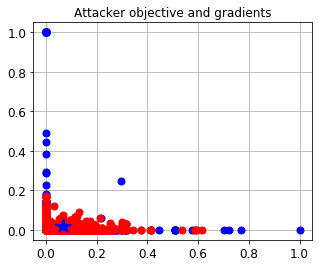

In [4]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]
test_x = data_test_array


df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]





#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
# clf = CClassifierRidge()
# clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
pois_attack = CAttackPoisoningSVM(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 450  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_svm_15 = pois_ds


# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))


Training of classifier complete!
Initial poisoning sample features: CArray([0.       0.       0.       ... 0.000941 0.001201 0.003409])
Initial poisoning sample label: 0
Attack started...
Attack complete!
Original accuracy on test set: 81.20%
Accuracy after attack on test set: 75.71%


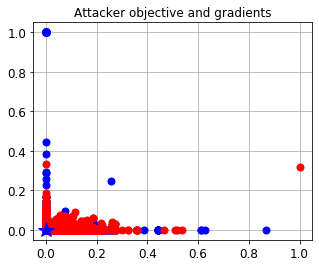

In [5]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]
test_x = data_test_array


df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]



#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
# clf = CClassifierRidge()
# clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
pois_attack = CAttackPoisoningSVM(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 600  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_svm_20 = pois_ds

# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))


Training of classifier complete!
Initial poisoning sample features: CArray([0.037445 0.       0.05098  ... 0.000647 0.001902 0.04072 ])
Initial poisoning sample label: 0
Attack started...
Attack complete!
Original accuracy on test set: 82.20%
Accuracy after attack on test set: 76.54%


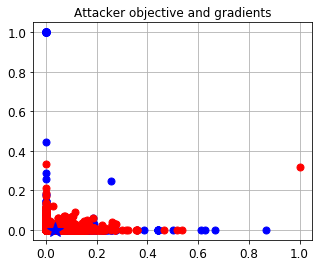

In [6]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]
test_x = data_test_array


df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]





#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
# clf = CClassifierRidge()
# clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
pois_attack = CAttackPoisoningSVM(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 750  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_svm_25 = pois_ds


# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))






Training of classifier complete!
Initial poisoning sample features: CArray([0.       0.       0.454902 ... 0.000747 0.003177 0.003274])
Initial poisoning sample label: 0
Attack started...
Attack complete!
Original accuracy on test set: 82.86%
Accuracy after attack on test set: 77.04%


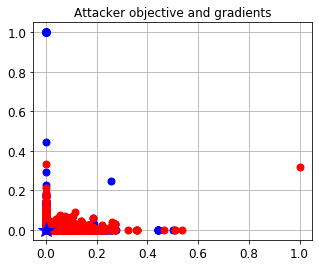

In [7]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]
test_x = data_test_array


df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]





#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
# clf = CClassifierRidge()
# clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
pois_attack = CAttackPoisoningSVM(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 900  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_svm_30 = pois_ds

# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))


Training of classifier complete!
Initial poisoning sample features: CArray([0.       0.       0.047059 ... 0.000672 0.021335 0.008838])
Initial poisoning sample label: 1
Attack started...
Attack complete!
Original accuracy on test set: 86.36%
Accuracy after attack on test set: 82.36%


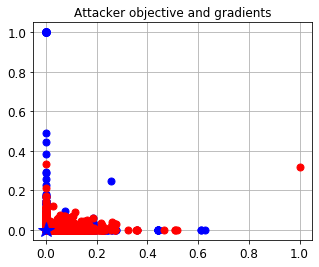

In [8]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]
test_x = data_test_array


df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]





#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
# clf = CClassifierRidge()
# clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
pois_attack = CAttackPoisoningSVM(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 1050  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_svm_35 = pois_ds

# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))


Training of classifier complete!
Initial poisoning sample features: CArray([0.       0.       0.       ... 0.000529 0.000701 0.001789])
Initial poisoning sample label: 0
Attack started...
Attack complete!
Original accuracy on test set: 82.70%
Accuracy after attack on test set: 75.04%


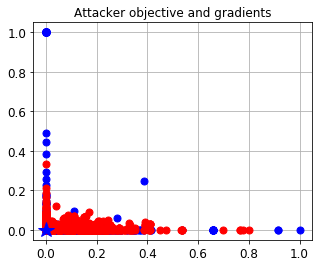

In [9]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]
test_x = data_test_array


df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]





#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
# clf = CClassifierRidge()
# clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
pois_attack = CAttackPoisoningSVM(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc

 

print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),(lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 1200  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_svm_40 = pois_ds


# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))


In [10]:
import numpy as np

pois_ds_svm_10_array = pois_ds_svm_10.X.tondarray()
pois_ds_svm_15_array = pois_ds_svm_15.X.tondarray()
pois_ds_svm_20_array = pois_ds_svm_20.X.tondarray()
pois_ds_svm_25_array = pois_ds_svm_25.X.tondarray()
pois_ds_svm_30_array = pois_ds_svm_30.X.tondarray()
pois_ds_svm_35_array = pois_ds_svm_35.X.tondarray()
pois_ds_svm_40_array = pois_ds_svm_40.X.tondarray()

# np.savetxt('logistic_pois_ds',(pois_ds_logistic_10_array,pois_ds_logistic_15_array,pois_ds_logistic_20_array,pois_ds_logistic_25_array,pois_ds_logistic_30_array,pois_ds_logistic_35_array,pois_ds_logistic_40_array),fmt='%s')

import pickle

with open('svm_pois_ds_10','wb') as file:
    pickle.dump(pois_ds_svm_10_array,file)
with open('svm_pois_ds_10', 'rb') as file_1:
    svm_pois_ds_array = pickle.load(file_1)
print(svm_pois_ds_array.shape)

with open('svm_pois_ds_15','wb') as file:
    pickle.dump(pois_ds_svm_15_array,file)
    
    
with open('svm_pois_ds_20','wb') as file:
    pickle.dump(pois_ds_svm_20_array,file)

with open('svm_pois_ds_25','wb') as file:
    pickle.dump(pois_ds_svm_25_array,file)

    
with open('svm_pois_ds_30','wb') as file:
    pickle.dump(pois_ds_svm_30_array,file)

with open('svm_pois_ds_35','wb') as file:
    pickle.dump(pois_ds_svm_35_array,file)
    
with open('svm_pois_ds_40','wb') as file:
    pickle.dump(pois_ds_svm_40_array,file)

pois_ds_svm_10_y_array = pois_ds_svm_10.Y.tondarray()
pois_ds_svm_15_y_array = pois_ds_svm_15.Y.tondarray()
pois_ds_svm_20_y_array = pois_ds_svm_20.Y.tondarray()
pois_ds_svm_25_y_array = pois_ds_svm_25.Y.tondarray()
pois_ds_svm_30_y_array = pois_ds_svm_30.Y.tondarray()
pois_ds_svm_35_y_array = pois_ds_svm_35.Y.tondarray()
pois_ds_svm_40_y_array = pois_ds_svm_40.Y.tondarray()
    
with open('svm_pois_ds_y_10','wb') as file:
    pickle.dump(pois_ds_svm_10_y_array,file)

with open('svm_pois_ds_y_15','wb') as file:
    pickle.dump(pois_ds_svm_15_y_array,file)

with open('svm_pois_ds_y_20','wb') as file:
    pickle.dump(pois_ds_svm_20_y_array,file)

with open('svm_pois_ds_y_25','wb') as file:
    pickle.dump(pois_ds_svm_25_y_array,file)

with open('svm_pois_ds_y_30','wb') as file:
    pickle.dump(pois_ds_svm_30_y_array,file)

with open('svm_pois_ds_y_35','wb') as file:
    pickle.dump(pois_ds_svm_35_y_array,file)

with open('svm_pois_ds_y_40','wb') as file:
    pickle.dump(pois_ds_svm_40_y_array,file)    
    

(300, 57)


## Generation of Poisoning Samples

We are going to generate an adversarial example against the SVM classifier
 using the **gradient-based** algorithm for generating poisoning attacks 
 proposed in: 
 
  > [[biggio12-icml]](https://arxiv.org/abs/1206.6389)
  > Biggio, B., Nelson, B. and Laskov, P., 2012. Poisoning attacks against 
  > support vector machines. In ICML 2012.

  > [[biggio15-icml]](https://arxiv.org/abs/1804.07933)
  > Xiao, H., Biggio, B., Brown, G., Fumera, G., Eckert, C. and Roli, F., 2015. 
  > Is feature selection secure against training data poisoning?. In ICML 2015.

  > [[demontis19-usenix]](
  > https://www.usenix.org/conference/usenixsecurity19/presentation/demontis)
  > Demontis, A., Melis, M., Pintor, M., Jagielski, M., Biggio, B., Oprea, A., 
  > Nita-Rotaru, C. and Roli, F., 2019. Why Do Adversarial Attacks Transfer? 
  > Explaining Transferability of Evasion and Poisoning Attacks. In 28th Usenix 
  > Security Symposium, Santa Clara, California, USA.

To compute a poisoning point, a bi-level optimization problem has to be solved, namely:

$$
\begin{aligned}
\max_{x_c}& A(D_{val}, \mathbf{w}^\ast) = \sum_{j=1}^m \ell(y_j, \mathbf{x_\mathit{j}}, \mathbf{w}^\ast)\\
&s.t. \mathbf{w}^\ast \in \underset{\mathbf{w}}{\operatorname{arg min}} \textit{L} (D_{tr} \cup (\mathbf{x}_c, y_c), \mathbf{w})
\end{aligned}
$$

Where $\mathbf{x_c}$ is the poisoning point, $A$ is the attacker objective function, $L$ is the classifier training
function. Moreover, $D_{tr}$ is the validation dataset and $D_{val}$ is the training dataset.
The former problem, along with the poisoning point $\mathbf{x}_c$ is used to train the classifier on the poisoned data,
while the latter is used to evaluate the performance on the untainted data.

The former equation depends on the classifier weights, which in turns, depends on the poisoning point.

This attack is implemented in SecML by different subclasses of the `CAttackPoisoning`.
 For the purpose of attacking a SVM classifier we use the `CAttackPoisoningSVM` 
 class.

As done for the [evasion attacks](03-Evasion.ipynb), let's specify the 
 parameters first. We set the bounds of the attack space to the known feature
 space given by validation dataset. Lastly, we chose the solver parameters for this specific optimization problem.

Let's start visualizing the objective function considering a single poisoning point.

Initial poisoning sample features: CArray([0.       0.       0.       ... 0.000529 0.000701 0.001789])
Initial poisoning sample label: 0


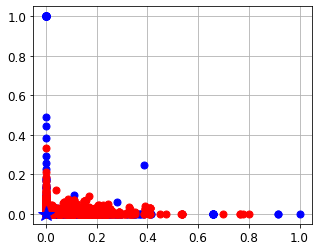

In [11]:
lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackPoisoningSVM
pois_attack = CAttackPoisoningSVM(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)




# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc


# print(xc)

print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))

from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)


# fig.sp.title('Attacker objective and gradients')
# fig.sp.plot_fun(
#     func=pois_attack.objective_function,
#     grid_limits=grid_limits, plot_levels=False,
#     n_grid_points=10, colorbar=True)
# # fig.show()

# # plot the box constraint
# from secml.optim.constraints import CConstraintBox
# box = fbox = CConstraintBox(lb=lb, ub=ub)
# fig.sp.plot_constraint(box, grid_limits=grid_limits,
#                        n_grid_points=10)


# fig.tight_layout()
# fig.show()

In [ ]:
lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackPoisoningRidge
pois_attack = CAttackPoisoningRidge(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc


print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))

from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)


fig.sp.title('Attacker objective and gradients')
fig.sp.plot_fun(
    func=pois_attack.objective_function,
    grid_limits=grid_limits, plot_levels=False,
    n_grid_points=10, colorbar=True)
# fig.show()

# plot the box constraint
from secml.optim.constraints import CConstraintBox
box = fbox = CConstraintBox(lb=lb, ub=ub)
fig.sp.plot_constraint(box, grid_limits=grid_limits,
                       n_grid_points=10)


fig.tight_layout()
fig.show()



In [ ]:
lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackPoisoningRidge
pois_attack = CAttackPoisoningRidge(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc

print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))

from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)


fig.sp.title('Attacker objective and gradients')
fig.sp.plot_fun(
    func=pois_attack.objective_function,
    grid_limits=grid_limits, plot_levels=False,
    n_grid_points=10, colorbar=True)
# fig.show()

# plot the box constraint
from secml.optim.constraints import CConstraintBox
box = fbox = CConstraintBox(lb=lb, ub=ub)
fig.sp.plot_constraint(box, grid_limits=grid_limits,
                       n_grid_points=10)


fig.tight_layout()
fig.show()



Now, we set the desired number of adversarial points to generate, 20 in this example.

In [ ]:
n_poisoning_points = 20  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))



We can see that the classifiers has been successfully attacked. To increase 
the attack power, more poisoning points can be crafted, at the expense of 
 a much slower optimization process.

Let's now visualize the attack on a 2D plane. We need to train a copy of the 
original classifier on the join between the training set and the poisoning points.

In [ ]:
# Training of the poisoned classifier
pois_clf = clf.deepcopy()
pois_tr = tr.append(pois_ds)  # Join the training set with the poisoning points
pois_clf.fit(pois_tr.X, pois_tr.Y)

# Define common bounds for the subplots
min_limit = min(pois_tr.X.min(), ts.X.min())
max_limit = max(pois_tr.X.max(), ts.X.max())
grid_limits = [[min_limit, max_limit], [min_limit, max_limit]]

fig = CFigure(10, 10)

fig.subplot(2, 2, 1)
fig.sp.title("Original classifier (training set)")
fig.sp.plot_decision_regions(
    clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(tr, markersize=5)
fig.sp.grid(grid_on=False)

fig.subplot(2, 2, 2)
fig.sp.title("Poisoned classifier (training set + poisoning points)")
fig.sp.plot_decision_regions(
    pois_clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(tr, markersize=5)
fig.sp.plot_ds(pois_ds, markers=['*', '*'], markersize=12)
fig.sp.grid(grid_on=False)

fig.subplot(2, 2, 3)
fig.sp.title("Original classifier (test set)")
fig.sp.plot_decision_regions(
    clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(ts, markersize=5)
fig.sp.text(0.05, -0.25, "Accuracy on test set: {:.2%}".format(acc), 
            bbox=dict(facecolor='white'))
fig.sp.grid(grid_on=False)

fig.subplot(2, 2, 4)
fig.sp.title("Poisoned classifier (test set)")
fig.sp.plot_decision_regions(
    pois_clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(ts, markersize=5)
fig.sp.text(0.05, -0.25, "Accuracy on test set: {:.2%}".format(pois_acc), 
            bbox=dict(facecolor='white'))
fig.sp.grid(grid_on=False)

fig.show()

We can see how the SVM classifier decision functions *changes* after injecting
 the adversarial poisoning points (blue and red stars).
 
For more details about poisoning adversarial attacks please refer to:

  > [[biggio18-pr]](https://arxiv.org/abs/1712.03141)
  > Biggio, B. and Roli, F., 2018. Wild patterns: Ten years after the rise of 
  > adversarial machine learning. In Pattern Recognition.

In [12]:
y_label = [0,0,1,1,1,0,0,0,0,1,1,1,1,0,0,1,0,0,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,0,1,0,0,1,1,0,0,1,1,0,1,1,1,0,1,1,0,1,0,1,1,1,0,1,0,1,1,1,0,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,0,1,1,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0,1,1,0,1,0,1,1,0,1,0,1,1,1,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,1,1,0,0,1,0,1,1,0,1,1,0,0,0,1,0,1,0,1,0,1,1,1,1,1,0,1,1,1,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,1,1,1,1,1,0,0,1,1,1,0,0,1,0,0,0,1,1,1,1,0,0,1,1,1,0,0,1,0,1,1,0,1,1,1,0,0,1,0,1,0,1,1,0,1,1,0,0,0,1,1,0,0,1,1,1,1,1,0,1,0,0,1,1,0,1,1,0,1,1,0,0,1,1,0,0,1,1,1,0,1,1,1,0,1,0,0,1,1,0,1,0,0,0,1,1,1,1]